# Identifying Fake Instagram Accounts

Growing a strong social media presence is important for some businesses. While a large number of followers is desirable, many Instagram growth tactics resort to boosting follower numbers through acquisition or purchase of robot or dummy accounts. These accounts provide no value to the influencer apart from artificially inflating the number of followers the influencer has. The presence of these fake accounts serves to dilute the engagement rates between influencers and their fans. Therefore, it is helpful to identify and remove such accounts from an influencer's page. For large influencer accounts with thousands of followers, the need to remove accounts in an automated way is necessary to reduce tedious work for an individual manageing a social-media presence--time better spent creating content and engaging with followers. 

Previously, simple methods based on follower-ratio or post count cut-offs have been used to reduce follower populations. Here, we instead investigate the use of machine learning models to identify fake accounts. To do so, the following steps have been taken:

1. Collect a list of followers for an influencer instagram account
2. Scrape relevant statistics for each follower. Here, we use the following statistics:
    + Number of Posts
    + Number of Followers
    + Number of Following
3. Building a training set
    + Select a subset of followers
    + Manually label accounts as real or fake 
4. Test machine learning models
    + Compare several models
    + Feature engineering - try to create new features to improve model performance
5. Build production model from full training set
6. Apply model to identify fake accounts in test set
7. Remove fake accounts from influencer's instagram following
8. Challenges & Next Steps
    + No Automated way to remove accounts
    + Resort to growth

## Takeaways

**Types of Fakes**

+ Over ~7K 
+ Abandoned accounts
+ Brazilian/Thai bot network - undesirable even if real 
+ Stolen photos
+ Generic photos
+ Inapporopriate content - lewd, graphic
+ Incoherent post history - geography/interests

**Development & Evaluation Process**

+ Simple algorithms
+ Feature engineering
+ Advanced algorithms
+ Comparison to standard methods (ie. cutoffs)
+ We want 0's -- we don't mind 1's, some fakes are OK--but we do not want to miss REAL followers. 
+ A high real recall score is necessary

In [2]:
import json, itertools, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Collect follower list

This was done using the InstaPy library authored by Tim Grossman. 

Here is a sample of the results:

In [3]:
with open('../data/followers-27-11-2018~full~23501.json') as f:
    followers = json.load(f)
    
sample_list = ['iamafakeuser_', '_an0th3r_fake', 'realperson', 'natgeo', 'catlover']
sample_list

['iamafakeuser_', '_an0th3r_fake', 'realperson', 'natgeo', 'catlover']

In [4]:
print('The client account has {} followers'.format(len(followers)))

The client account has 23501 followers


## 2. Scrape Follower Attributes

This was done by modifying the InstaPy source code to add functionality and extract post and follower counts. The following information was retreived and saved to a .csv file:

    + Number of Posts
    + Number of Followers
    + Number of accounts Followed

In [5]:
data = pd.read_csv('../data/follower-stats.txt', delim_whitespace=True)

# select columns to show for anonymity
cols_to_show = ['posts', 'followers', 'following']

data[cols_to_show].head()

,posts,followers,following
0,0,685,6700
1,278,2877,2093
2,229,1359,862
3,320,3071,7306
4,66,2505,388


In [6]:
# Identify and remove usernames that have been changed
changed_users = data[data.posts=='None']['username']
changed_indices = changed_users.index
changed_user_names = changed_users.values

# write changed names to file
#with open('../data/changed_users.json', 'w') as fp:  
#    json.dump(changed_user_names.tolist(), fp)

# create a df with active users only
active_users = data.drop(labels=changed_indices)

In [7]:
len(active_users)

23375

## 3. Build Training Set

+ Select subset
+ Manually label as Real/Fake

** Subset selection **

In [8]:
# or use DataFrame.sample()

subset_percentage = 0.05

# training set - use a random_state for reproducability
data_train = active_users.sample(frac=subset_percentage, random_state=0)

# test set
data_test = active_users.drop(data_train.index)

# Save train & test set data -- comment to avoid overwriting
#data_train.to_csv('../data/train.csv')
#data_test.to_csv('../data/test.csv')

data_train[cols_to_show].head()

,posts,followers,following
14202,3,876,7202
15214,61,81,5929
7839,42,26,326
16190,14,48,1454
19924,32,207,6556


** Manually Labeled Subset **

In [9]:
# Updated to standardize manual labels
labeled_train = pd.read_csv('../data/labeled_train_updated_tester_all.csv', index_col=0, usecols=[0,1,2,3,4,5,6])
labeled_train.columns

Index(['username', 'posts', 'followers', 'following', 'fake', 'tester'], dtype='object')

In [10]:
cols_to_show_labeled = ['posts', 'followers', 'following', 'fake']
target_col = 'fake'

labeled_train[cols_to_show_labeled].head()

,posts,followers,following,fake
14202,3,876,7202,0
15214,61,81,5929,0
7839,42,26,326,1
16190,14,48,1454,0
19924,32,207,6556,0


** Check for consistency **

In [11]:
labeled_train.isnull().sum()

username     0
posts        0
followers    0
following    0
fake         0
tester       0
dtype: int64

In [13]:
labeled_train.fake.unique()

array([0, 1])

In [14]:
# clean up labels
labeled_train.fake.replace(to_replace='o', value=0, inplace=True)
labeled_train.fake = labeled_train.fake.apply(lambda x: int(x))
labeled_train.fake.value_counts()

1    1037
0     132
Name: fake, dtype: int64

** Tester 3 has a higher number of real accounts. Possibly less discerning **

+ Tester 3 is definitely more leninent (went from 100 to 40!)
+ Do the same for testers 2 and 4
+ Test without editing
+ If results are poor, re-visit and edit labels (7Ks)

In [15]:
labeled_train.groupby('tester')['fake'].value_counts()

tester  fake
four    1       246
        0        24
one     1       256
        0        43
three   1       260
        0        40
two     1       275
        0        25
Name: fake, dtype: int64

** Feature Engineering **

+ ratio
+ has number

In [17]:
labeled_train.columns

Index(['username', 'posts', 'followers', 'following', 'fake', 'tester'], dtype='object')

## Feature Engineering

In [16]:
# update to handle 0s
labeled_train['ratio'] = labeled_train.followers/labeled_train.following
labeled_train['has_number'] = labeled_train.username.apply(lambda user: any(c.isdigit() for c in user)).astype(int)
labeled_train['ends_number'] = labeled_train.username.apply(lambda user: user[-1].isdigit()).astype(int)

eng_feats = ['ratio', 'has_number', 'ends_number']

labeled_train[cols_to_show_labeled+eng_feats].head()

,posts,followers,following,fake,ratio,has_number,ends_number
14202,3,876,7202,0,0.121633,1,1
15214,61,81,5929,0,0.013662,1,0
7839,42,26,326,1,0.079755,0,0
16190,14,48,1454,0,0.033012,1,1
19924,32,207,6556,0,0.031574,0,0


Text(0.5,0,'# following')

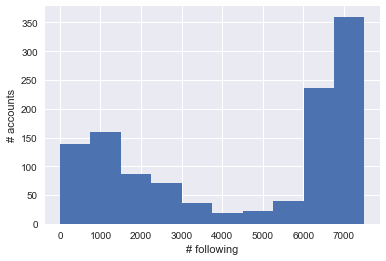

In [17]:
labeled_train.following.hist()
plt.ylabel('# accounts')
plt.xlabel('# following')

## Learning Model Prototype

In [18]:
cols_to_show_training = ['posts', 'followers', 
                         'following', 'fake', 'tester',
                         'ratio', 'has_number', 'ends_number']

In [19]:
labeled_train[cols_to_show_training].head()

,posts,followers,following,fake,tester,ratio,has_number,ends_number
14202,3,876,7202,0,one,0.121633,1,1
15214,61,81,5929,0,one,0.013662,1,0
7839,42,26,326,1,one,0.079755,0,0
16190,14,48,1454,0,one,0.033012,1,1
19924,32,207,6556,0,one,0.031574,0,0


In [21]:
# define labels (this can change -- also this process can be automated to update different feature combinations)
X_labels = ['posts', 'followers', 'following', 'ratio', 'has_number', 'ends_number']
y_label = 'fake'

X = labeled_train[X_labels]
y = labeled_train[y_label]

In [22]:
X.head()

,posts,followers,following,ratio,has_number,ends_number
14202,3,876,7202,0.121633,1,1
15214,61,81,5929,0.013662,1,0
7839,42,26,326,0.079755,0,0
16190,14,48,1454,0.033012,1,1
19924,32,207,6556,0.031574,0,0


**split training and testing set**

Make sure all comparisons are made on the SAME split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
X_train.head()

,posts,followers,following,ratio,has_number,ends_number
22504,0,44,6483,0.006787,0,0
7096,21,18,2026,0.008885,0,0
21855,2,92,6524,0.014102,0,0
7025,1,313,7159,0.043721,1,0
6833,26,41,2226,0.018419,0,0


In [25]:
base_feats = ['posts', 'followers', 'following']
eng_feats

['ratio', 'has_number', 'ends_number']

** Create a pipeline function to train & test model, print output **

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [27]:
def evaluate_model(X, y, model_name, random_state=0, confusion=True):
    '''Select X features when calling the function
    
    Add k-fold, report variance and mean?
    
    Add confusion?
    '''
    
    # create train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    # get model
    model = model_name
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    
    # print metrics
    #print('--- /// BASE MODEL /// ---')
    print('--- Classification Report ---')
    print(classification_report(y_test, y_predicted, labels=[0,1], target_names=['Real', 'Fake']))
    print('--- Confusion Matrix ---')
    print(confusion_matrix(y_test, y_predicted))
    
    if confusion:
        plot_confusion_matrix(confusion_matrix(y_test, y_predicted), classes=['Real', 'Fake'],
                      title='Confusion matrix')
    else:
        pass

** Logistic Regression **

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.82      0.30      0.44        30
       Fake       0.93      0.99      0.96       263

avg / total       0.91      0.92      0.90       293

--- Confusion Matrix ---
[[  9  21]
 [  2 261]]


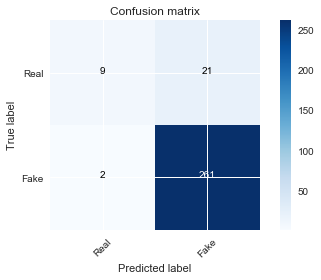

In [28]:
evaluate_model(X[base_feats], y, LogisticRegression())

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.85      0.37      0.51        30
       Fake       0.93      0.99      0.96       263

avg / total       0.92      0.93      0.92       293

--- Confusion Matrix ---
[[ 11  19]
 [  2 261]]


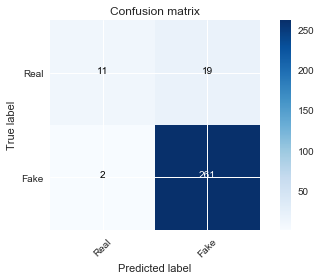

In [29]:
# using engineed features
evaluate_model(X, y, LogisticRegression())

** Random Forest **

+ Original Recall of "real" was 0.52
+ Updated recall is 0.62! (tester 3)
+ Updated recall is 0.67! (all testers)

--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.67      0.60      0.63        30
       Fake       0.95      0.97      0.96       263

avg / total       0.93      0.93      0.93       293

--- Confusion Matrix ---
[[ 18  12]
 [  9 254]]


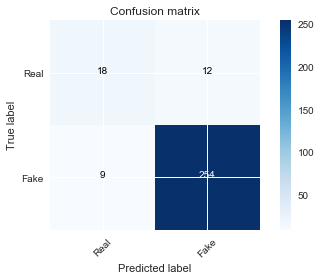

In [56]:
evaluate_model(X[base_feats], y, RandomForestClassifier())

--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.72      0.70      0.71        30
       Fake       0.97      0.97      0.97       263

avg / total       0.94      0.94      0.94       293

--- Confusion Matrix ---
[[ 21   9]
 [  8 255]]


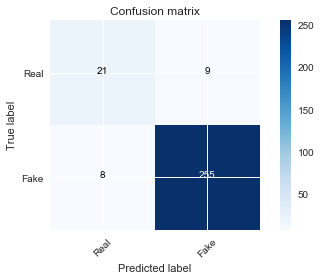

In [57]:
evaluate_model(X, y, RandomForestClassifier())

** We want near 1.00 recall on real accounts. **

**KNN**

+ original - 0.42 recall
+ updated - 0.63 recall 

--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.83      0.63      0.72        30
       Fake       0.96      0.98      0.97       263

avg / total       0.95      0.95      0.95       293

--- Confusion Matrix ---
[[ 19  11]
 [  4 259]]


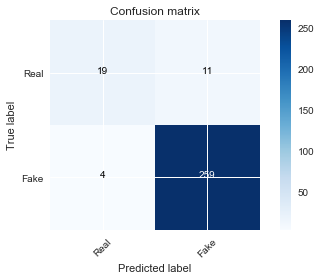

In [58]:
evaluate_model(X[base_feats], y, KNeighborsClassifier())

--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.83      0.63      0.72        30
       Fake       0.96      0.98      0.97       263

avg / total       0.95      0.95      0.95       293

--- Confusion Matrix ---
[[ 19  11]
 [  4 259]]


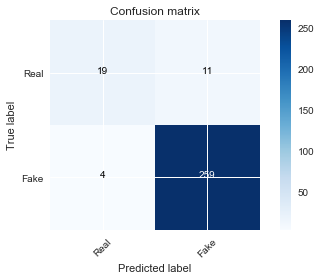

In [59]:
evaluate_model(X, y, KNeighborsClassifier())

** Additional Models **

+ LDA
+ Naive Bayes
+ Decision Tree
+ SVM
+ Boosting

In [71]:
from sklearn.naive_bayes import GaussianNB

In [75]:
# Instantiate the Model
gnb_base = GaussianNB()

# Fit the model
gnb_base.fit(X_train[base_feats], y_train)

# Predict
y_pred_gnb_base = gnb_base.predict(X_test[base_feats])

# Compare the results
print('--- \\\ GAUSSIAN NB CLASSIFIER /// ---')
print('--- /// BASE MODEL /// ---')
print('--- Classification Report ---')
print(classification_report(y_test, y_pred_gnb_base, labels=[0,1], target_names=['Real', 'Fake']))
print('--- Confusion Matrix ---')
print(confusion_matrix(y_test, y_pred_gnb_base))

--- \\ GAUSSIAN NB CLASSIFIER /// ---
--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.85      0.17      0.28        65
       Fake       0.81      0.99      0.89       228

avg / total       0.82      0.81      0.75       293

--- Confusion Matrix ---
[[ 11  54]
 [  2 226]]


In [76]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the Model
dt_base = DecisionTreeClassifier()

# Fit the model
dt_base.fit(X_train[base_feats], y_train)

# Predict
y_pred_dt_base = dt_base.predict(X_test[base_feats])

# Compare the results
print('--- \\\ GAUSSIAN NB CLASSIFIER /// ---')
print('--- /// BASE MODEL /// ---')
print('--- Classification Report ---')
print(classification_report(y_test, y_pred_dt_base, labels=[0,1], target_names=['Real', 'Fake']))
print('--- Confusion Matrix ---')
print(confusion_matrix(y_test, y_pred_dt_base))

--- \\ GAUSSIAN NB CLASSIFIER /// ---
--- /// BASE MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.65      0.60      0.62        65
       Fake       0.89      0.91      0.90       228

avg / total       0.84      0.84      0.84       293

--- Confusion Matrix ---
[[ 39  26]
 [ 21 207]]


In [77]:
# Instantiate the Model
dt_eng = DecisionTreeClassifier()

# Fit the model
dt_eng.fit(X_train[base_feats+eng_feats], y_train)

# Predict
y_pred_dt_eng = dt_eng.predict(X_test[base_feats+eng_feats])

# Compare the results
print('--- \\\ dtree CLASSIFIER /// ---')
print('--- /// ENGINEERED MODEL /// ---')
print('--- Classification Report ---')
print(classification_report(y_test, y_pred_dt_eng, labels=[0,1], target_names=['Real', 'Fake']))
print('--- Confusion Matrix ---')
print(confusion_matrix(y_test, y_pred_dt_eng))

--- \\ dtree CLASSIFIER /// ---
--- /// ENGINEERED MODEL /// ---
--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.64      0.55      0.60        65
       Fake       0.88      0.91      0.89       228

avg / total       0.83      0.83      0.83       293

--- Confusion Matrix ---
[[ 36  29]
 [ 20 208]]


## Add kfold to workflow

In [79]:
from sklearn.model_selection import KFold

## Undersampling

+ This might help improve recall
+ Under OR over sample is possible

In [47]:
X.head(2)

,posts,followers,following,ratio,has_number,ends_number
14202,3,876,7202,0.121633,1,1
15214,61,81,5929,0.013662,1,0


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

** Undersampling **

TOO SMALL TRY OVERSAMPLING!

In [16]:
# Instantiate and fit undersample model
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

# split train and test sets or perform kfold cross validation
#X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(X_rus, y_rus, random_state=0)
skf = StratifiedKFold(n_splits=10, random_state=0)
skf.get_n_splits(X_rus, y_rus)

10

In [17]:
X_rus.shapes

(264, 6)

In [88]:
print('LOGISTIC REGRESSION')
for k, (train, test) in enumerate(skf.split(X_rus, y_rus)):
    lr_kfold = LogisticRegression()
    lr_kfold.fit(X_rus[train], y_rus[train])
    y_pred_kfold = lr_kfold.predict(X_rus[test])
    print('--- Fold {} ---'.format(k+1))
    print(classification_report(y_rus[test], y_pred_kfold, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_rus[test], y_pred_kfold))

LOGISTIC REGRESSION
--- Fold 1 ---
             precision    recall  f1-score   support

       Real       0.88      0.50      0.64        14
       Fake       0.65      0.93      0.76        14

avg / total       0.76      0.71      0.70        28

[[ 7  7]
 [ 1 13]]
--- Fold 2 ---
             precision    recall  f1-score   support

       Real       1.00      1.00      1.00        14
       Fake       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00        28

[[14  0]
 [ 0 14]]
--- Fold 3 ---
             precision    recall  f1-score   support

       Real       0.86      0.92      0.89        13
       Fake       0.92      0.85      0.88        13

avg / total       0.89      0.88      0.88        26

[[12  1]
 [ 2 11]]
--- Fold 4 ---
             precision    recall  f1-score   support

       Real       1.00      1.00      1.00        13
       Fake       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00        26

[[1

In [89]:
print('RANDOM FOREST CLASSIFIER')
for k, (train, test) in enumerate(skf.split(X_rus, y_rus)):
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(X_rus[train], y_rus[train])
    y_pred_kfold = rfc_kfold.predict(X_rus[test])
    print('--- Fold {} ---'.format(k+1))
    print(classification_report(y_rus[test], y_pred_kfold, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_rus[test], y_pred_kfold))

RANDOM FOREST CLASSIFIER
--- Fold 1 ---
             precision    recall  f1-score   support

       Real       1.00      0.57      0.73        14
       Fake       0.70      1.00      0.82        14

avg / total       0.85      0.79      0.78        28

[[ 8  6]
 [ 0 14]]
--- Fold 2 ---
             precision    recall  f1-score   support

       Real       0.93      1.00      0.97        14
       Fake       1.00      0.93      0.96        14

avg / total       0.97      0.96      0.96        28

[[14  0]
 [ 1 13]]
--- Fold 3 ---
             precision    recall  f1-score   support

       Real       0.87      1.00      0.93        13
       Fake       1.00      0.85      0.92        13

avg / total       0.93      0.92      0.92        26

[[13  0]
 [ 2 11]]
--- Fold 4 ---
             precision    recall  f1-score   support

       Real       0.87      1.00      0.93        13
       Fake       1.00      0.85      0.92        13

avg / total       0.93      0.92      0.92        26

** Oversampling **

LOOKS GOOD! 

In [18]:
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)
X_ros.shape

(2074, 6)

In [20]:
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros, y_ros, random_state=0)

In [21]:
logreg_ros = LogisticRegression()
logreg_ros.fit(X_ros_train, y_ros_train)
y_pred_logreg_ros_base = logreg_ros.predict(X_ros_test)
print('LOGISTIC REGRESSION WITH OVERSAMPLING')
print(classification_report(y_ros_test, y_pred_logreg_ros_base, labels=[0,1], target_names=['Real', 'Fake']))
print(confusion_matrix(y_ros_test, y_pred_logreg_ros_base))

LOGISTIC REGRESSION WITH OVERSAMPLING
             precision    recall  f1-score   support

       Real       0.88      0.88      0.88       257
       Fake       0.89      0.88      0.88       262

avg / total       0.88      0.88      0.88       519

[[227  30]
 [ 31 231]]


In [22]:
rfc_ros = RandomForestClassifier()
rfc_ros.fit(X_ros_train, y_ros_train)
y_pred_rfc_ros_base = rfc_ros.predict(X_ros_test)
print('RANDOM FOREST CLASSIFIER WITH OVERSAMPLING')
print(classification_report(y_ros_test, y_pred_rfc_ros_base, labels=[0,1], target_names=['Real', 'Fake']))
print(confusion_matrix(y_ros_test, y_pred_rfc_ros_base))

RANDOM FOREST CLASSIFIER WITH OVERSAMPLING
             precision    recall  f1-score   support

       Real       0.96      1.00      0.98       257
       Fake       1.00      0.96      0.98       262

avg / total       0.98      0.98      0.98       519

[[257   0]
 [ 10 252]]


## Perform k-fold cross validation on oversampled dataset

In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0)
skf.get_n_splits(X_ros, y_ros)

10

In [24]:
for k, (train, test) in enumerate(skf.split(X_ros, y_ros)):
    lr_kfold = LogisticRegression()
    lr_kfold.fit(X_ros[train], y_ros[train])
    y_pred_kfold = lr_kfold.predict(X_ros[test])
    print('--- Fold {} ---'.format(k+1))
    print(classification_report(y_ros[test], y_pred_kfold, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_ros[test], y_pred_kfold))

--- Fold 1 ---
             precision    recall  f1-score   support

       Real       0.87      0.87      0.87       104
       Fake       0.87      0.88      0.87       104

avg / total       0.87      0.87      0.87       208

[[90 14]
 [13 91]]
--- Fold 2 ---
             precision    recall  f1-score   support

       Real       0.89      0.89      0.89       104
       Fake       0.89      0.89      0.89       104

avg / total       0.89      0.89      0.89       208

[[93 11]
 [11 93]]
--- Fold 3 ---
             precision    recall  f1-score   support

       Real       0.83      0.88      0.85       104
       Fake       0.87      0.82      0.84       104

avg / total       0.85      0.85      0.85       208

[[91 13]
 [19 85]]
--- Fold 4 ---
             precision    recall  f1-score   support

       Real       0.88      0.88      0.88       104
       Fake       0.88      0.88      0.88       104

avg / total       0.88      0.88      0.88       208

[[91 13]
 [12 92]]
--- 

In [25]:
for k, (train, test) in enumerate(skf.split(X_ros, y_ros)):
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(X_ros[train], y_ros[train])
    y_pred_kfold = rfc_kfold.predict(X_ros[test])
    print('--- Fold {} ---'.format(k+1))
    print(classification_report(y_ros[test], y_pred_kfold, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_ros[test], y_pred_kfold))

--- Fold 1 ---
             precision    recall  f1-score   support

       Real       0.99      1.00      1.00       104
       Fake       1.00      0.99      1.00       104

avg / total       1.00      1.00      1.00       208

[[104   0]
 [  1 103]]
--- Fold 2 ---
             precision    recall  f1-score   support

       Real       0.99      1.00      1.00       104
       Fake       1.00      0.99      1.00       104

avg / total       1.00      1.00      1.00       208

[[104   0]
 [  1 103]]
--- Fold 3 ---
             precision    recall  f1-score   support

       Real       0.96      1.00      0.98       104
       Fake       1.00      0.96      0.98       104

avg / total       0.98      0.98      0.98       208

[[104   0]
 [  4 100]]
--- Fold 4 ---
             precision    recall  f1-score   support

       Real       0.96      1.00      0.98       104
       Fake       1.00      0.96      0.98       104

avg / total       0.98      0.98      0.98       208

[[104   0]


** Oversample comparing regular and engineered features **

In [26]:
# Instantiate and fit undersample model
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)

# split train and test sets or perform kfold cross validation
#X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(X_rus, y_rus, random_state=0)
skf = StratifiedKFold(n_splits=10, random_state=0)
skf.get_n_splits(X_ros, y_ros)

# Test
# X_rus[test][:,0:3] -- select only base features

print('RANDOM FOREST CLASSIFIER')

for k, (train, test) in enumerate(skf.split(X_ros, y_ros)):
    
    print('--- Fold {} ---'.format(k+1))
        
    # base 
    print('- Base Features -')
    rfc_kf_base = RandomForestClassifier()
    rfc_kf_base.fit(X_ros[train][:,0:3], y_ros[train])
    y_kf_base = rfc_kf_base.predict(X_ros[test][:,0:3])
    
    print(classification_report(y_ros[test], y_kf_base, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_ros[test], y_kf_base))
    
    # engineered
    print('- Engineered Features -')
    rfc_kf_eng = RandomForestClassifier()
    rfc_kf_eng.fit(X_ros[train], y_ros[train])
    y_kf_eng = rfc_kf_eng.predict(X_ros[test])
    
    print(classification_report(y_ros[test], y_kf_eng, labels=[0,1], target_names=['Real', 'Fake']))
    print(confusion_matrix(y_ros[test], y_kf_eng))

RANDOM FOREST CLASSIFIER
--- Fold 1 ---
- Base Features -
             precision    recall  f1-score   support

       Real       0.98      1.00      0.99       104
       Fake       1.00      0.98      0.99       104

avg / total       0.99      0.99      0.99       208

[[104   0]
 [  2 102]]
- Engineered Features -
             precision    recall  f1-score   support

       Real       1.00      1.00      1.00       104
       Fake       1.00      1.00      1.00       104

avg / total       1.00      1.00      1.00       208

[[104   0]
 [  0 104]]
--- Fold 2 ---
- Base Features -
             precision    recall  f1-score   support

       Real       0.97      1.00      0.99       104
       Fake       1.00      0.97      0.99       104

avg / total       0.99      0.99      0.99       208

[[104   0]
 [  3 101]]
- Engineered Features -
             precision    recall  f1-score   support

       Real       0.97      1.00      0.99       104
       Fake       1.00      0.97      0.

In [30]:
print('Set     Samples     Fakes')
print('Test:     ', len(y_ros[train]), '     ',sum(y_ros[train]))
print('Training:  ', len(y_ros[test]), '     ' ,sum(y_ros[test]))

Set     Samples     Fakes
Test:      1868       934
Training:   206       103


## Training final model on full oversampled dataset

+ Base feature model
+ Engineered feature model

In [33]:
# base
rfc_base_final = RandomForestClassifier()
rfc_base_final.fit(X_ros[:,0:3], y_ros)
#pickle.dump(rfc_base_final, open('../models/final_rfc_base.sav', 'wb'))

# engineered
rfc_eng_final = RandomForestClassifier()
rfc_eng_final.fit(X_ros, y_ros)
#pickle.dump(rfc_eng_final, open('../models/final_rfc_eng.sav', 'wb'))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
loaded_model = pickle.load(open('../models/final_rfc_base.sav', 'rb'))
loaded_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
loaded_model.predict(X_ros[0:20,0:3])

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

In [36]:
y_ros[0:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

** Predict full follower list real/fake **

In [37]:
unlabeled_test = pd.read_csv('../data/test.csv', index_col=0)
unlabeled_test['ratio'] = unlabeled_test.followers/unlabeled_test.following
unlabeled_test['has_number'] = unlabeled_test.username.apply(lambda user: any(c.isdigit() for c in user)).astype(int)
unlabeled_test['ends_number'] = unlabeled_test.username.apply(lambda user: user[-1].isdigit()).astype(int)
unlabeled_test.drop('username',axis=1).head()

,posts,followers,following,ratio,has_number,ends_number
0,0,685,6700,0.102239,0,0
1,278,2877,2093,1.374582,0,0
2,229,1359,862,1.576566,0,0
3,320,3071,7306,0.420339,0,0
4,66,2505,388,6.456186,0,0


In [38]:
loaded_rfc_model_base = pickle.load(open('../models/final_rfc_base.sav', 'rb'))
loaded_rfc_model_eng = pickle.load(open('../models/final_rfc_eng.sav', 'rb'))

In [39]:
y_unlabeled_test = loaded_rfc_model_eng.predict(unlabeled_test[base_feats+eng_feats])
y_unlabeled_test

array([1, 0, 0, ..., 1, 0, 0])

In [40]:
unlabeled_test['fake'] = y_unlabeled_test
unlabeled_test.drop('username',axis=1).head()

,posts,followers,following,ratio,has_number,ends_number,fake
0,0,685,6700,0.102239,0,0,1
1,278,2877,2093,1.374582,0,0,0
2,229,1359,862,1.576566,0,0,0
3,320,3071,7306,0.420339,0,0,1
4,66,2505,388,6.456186,0,0,0


In [42]:
# get a list of real followers
real_test = unlabeled_test[unlabeled_test.fake==0].username.values
real_train = labeled_train[labeled_train.fake==0].username.values
real_followers = np.append(real_test, real_train)

# fake followers
fake_test = unlabeled_test[unlabeled_test.fake==1].username.values
fake_train = labeled_train[labeled_train.fake==1].username.values
fake_followers = np.append(fake_test, fake_train)

print('real: {}, fake: {}, total: {}'.format(len(real_followers), 
                                           len(fake_followers), 
                                           len(real_followers) + len(fake_followers)))

real: 2717, fake: 20658, total: 23375
